## Loan Default: EDA & Prediction - rough draft <br>
Whitney Rueckl <br>

In [1]:
# Pandas & Numpy - data manipulation (dataframes & arrays)
import pandas as pd
import numpy as np
import math

# OS - for a function to get the working directory
import os
import time
import missingno as msno

#matplotlib - functions for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go

#Seaborn - for statistical plotting & visualization
import seaborn as sns; sns.set()

# Packages for modeling:
# Sklearn - machine learning
import sklearn
#from sklearn.metrics import f1_score
from sklearn import model_selection
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error #f1_score, precision_score, recall_score, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# for sklearn contrib library category_encoders.Binary.BinaryEncoder
import category_encoders as ce

#from sklearn.linear_model import LinearRegression
import xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

# Supress scientific notation for large numbers
pd.options.display.float_format = '{:.2f}'.format

# Import garbage collector module for viewing objects in environemnt 
# https://docs.python.org/3/library/gc.html
import gc



# https://ipython-books.github.io/61-using-matplotlib-styles/

# from os import listdir
# from os.path import isfile, join

# onlyfiles = [f for f in listdir(os.getcwd()) if isfile(join(os.getcwd(), f))]
# onlyfiles

C:\Users\whitn\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Define functions:

#### Load data

In [2]:
# Read data from csv
df_raw = pd.read_csv(str(os.getcwd()) + '\\Read_Only_Data\\loan_default_data.csv')

# set number of columns datfame will display
pd.set_option("display.max_columns", df_raw.shape[-1]) 

df_raw.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.00,not_neg,not_int,not_lpsm,118000.00,sb,pr,home,1U,1740.00,EXP,758,CIB,25-34,to_inst,98.73,south,direct,1,45.00
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.00,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,4980.00,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.20,595.00,360.00,neg_amm,not_int,not_lpsm,508000.00,sb,pr,home,1U,9480.00,EXP,834,CIB,35-44,to_inst,80.02,south,direct,0,46.00
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.68,NaN,360.00,not_neg,not_int,not_lpsm,658000.00,sb,pr,home,1U,11880.00,EXP,587,CIB,45-54,not_inst,69.38,North,direct,0,42.00
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.30,0.00,360.00,not_neg,not_int,not_lpsm,758000.00,sb,pr,home,1U,10440.00,CRIF,602,EXP,25-34,not_inst,91.89,North,direct,0,39.00


In [3]:
df_raw.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.00,148670.00,148670.00,112231.00,112031.00,109028.00,148629.00,133572.00,139520.00,148670.00,133572.00,148670.00,124549.00
mean,99224.50,2019.00,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,0.25,37.73
std,42917.48,0.00,183909.31,0.56,0.51,3251.12,58.41,359935.32,6496.59,115.88,39.97,0.43,10.55
min,24890.00,2019.00,16500.00,0.00,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,0.00,5.00
25%,62057.25,2019.00,196500.00,3.62,0.08,581.49,360.00,268000.00,3720.00,599.00,60.47,0.00,31.00
50%,99224.50,2019.00,296500.00,3.99,0.39,2596.45,360.00,418000.00,5760.00,699.00,75.14,0.00,39.00
75%,136391.75,2019.00,436500.00,4.38,0.78,4812.50,360.00,628000.00,8520.00,800.00,86.18,0.00,45.00
max,173559.00,2019.00,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,1.00,61.00


#### Clean up column names

In [4]:
data = df_raw.copy()

In [5]:
# Convert columns to snake case (my preference)
data.columns = data.columns.str.lower().str.replace(' ','_')

#### View unique values each of the categorical columns

In [199]:
#print("Number of unique values in each column: ", '\n', data.nunique())

In [200]:
# No duplicate IDs
#data['id'].duplicated.sum()

In [6]:
# there is only one year in the dataset and no duplicated ids so let's drop these columns. 
# If there were duplicated ids I would need to deal with those.
data = data.drop(['id', 'year'], axis = 1)

In [7]:
# Identify and list numeric type columns only
numeric_cols = list(data.select_dtypes('number').columns)
print(numeric_cols, '\n')

# Identify and list object type (categorical) columns only - dropping model for now because so many models in set
object_cols = list((data.select_dtypes('object').columns))
print(object_cols, '\n')

['loan_amount', 'rate_of_interest', 'interest_rate_spread', 'upfront_charges', 'term', 'property_value', 'income', 'credit_score', 'ltv', 'status', 'dtir1'] 

['loan_limit', 'gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'credit_worthiness', 'open_credit', 'business_or_commercial', 'neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'region', 'security_type'] 



In [ ]:
# for i in object_cols:
#     print(i, data[i].unique(), sep=':\n', end='\n\n')

# # Count number of unique values in all columns
# print("Number of unique values in each column: ", '\n', data.nunique())

In [8]:
# See % of data that is in each group within each categorical column:
for col_i in object_cols:
    total = data.shape[0]
    cnt = data.groupby(col_i)[col_i].count()
    perc = cnt/total
    print(perc)

loan_limit
cf    0.91
ncf   0.07
Name: loan_limit, dtype: float64
gender
Female              0.18
Joint               0.28
Male                0.28
Sex Not Available   0.25
Name: gender, dtype: float64
approv_in_adv
nopre   0.84
pre     0.16
Name: approv_in_adv, dtype: float64
loan_type
type1   0.76
type2   0.14
type3   0.10
Name: loan_type, dtype: float64
loan_purpose
p1   0.23
p2   0.02
p3   0.38
p4   0.37
Name: loan_purpose, dtype: float64
credit_worthiness
l1   0.96
l2   0.04
Name: credit_worthiness, dtype: float64
open_credit
nopc   1.00
opc    0.00
Name: open_credit, dtype: float64
business_or_commercial
b/c     0.14
nob/c   0.86
Name: business_or_commercial, dtype: float64
neg_ammortization
neg_amm   0.10
not_neg   0.90
Name: neg_ammortization, dtype: float64
interest_only
int_only   0.05
not_int    0.95
Name: interest_only, dtype: float64
lump_sum_payment
lpsm       0.02
not_lpsm   0.98
Name: lump_sum_payment, dtype: float64
construction_type
mh   0.00
sb   1.00
Name: construct

#### Notes:
- 100% of these loans are secured by "home"... maybe mortages???

In [9]:
# deleting some columns that have veyr high percent in one category or another
del_obj_cols = ['open_credit', 'construction_type', 'secured_by', 'total_units', 'security_type', 'region']
object_cols = list(set(list(object_cols)) - set(list(del_obj_cols )))
len(object_cols)

data = data.drop(del_obj_cols, axis = 1)

In [10]:
#data.to_csv('data_prepped_V1.csv', index=False)

## Data Exploration: exploring missing values in the dataset
---

In [10]:
#display(data.isnull().sum())
def createMissingSummary(df):
    col_lst = []
    per_lst = []
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        #print("{} : {} ({}%)".format(col, null_count, round(per, 3)))        
        col_lst.append(col)
        per_lst.append(per)
        #zipped = list(zip(col_lst, per_lst))
        df_results = pd.DataFrame({'column_nm':col_lst, 'missing_percent':per_lst})
    return df_results

In [11]:
#missing_percent = get_missing_numerical_summary(data)
#missing_percent
df_missing = pd.DataFrame(createMissingSummary(data))
df_missing

,column_nm,missing_percent
0,loan_limit,2.25
1,approv_in_adv,0.61
2,loan_purpose,0.09
3,rate_of_interest,24.51
4,interest_rate_spread,24.64
5,upfront_charges,26.66
6,term,0.03
7,neg_ammortization,0.08
8,property_value,10.16
9,income,6.15


In [13]:
missing_cols = [col for col in data.columns if data[col].isnull().sum() > 0]
#missing_cols

Some attributes have a high % of missing values, such as the interest rate, interest rate spread, and upfront charges for which >24% of the value are missing...it's tempting to just drop all records with missing values but will seee later that that results in removing all of the positive classes (default = 1) 

#### Visualizing missing data
https://towardsdatascience.com/visualizing-missing-values-in-python-is-shockingly-easy-56ed5bc2e7ea

A matrix of missing data: the white lines indicate missing data in each column

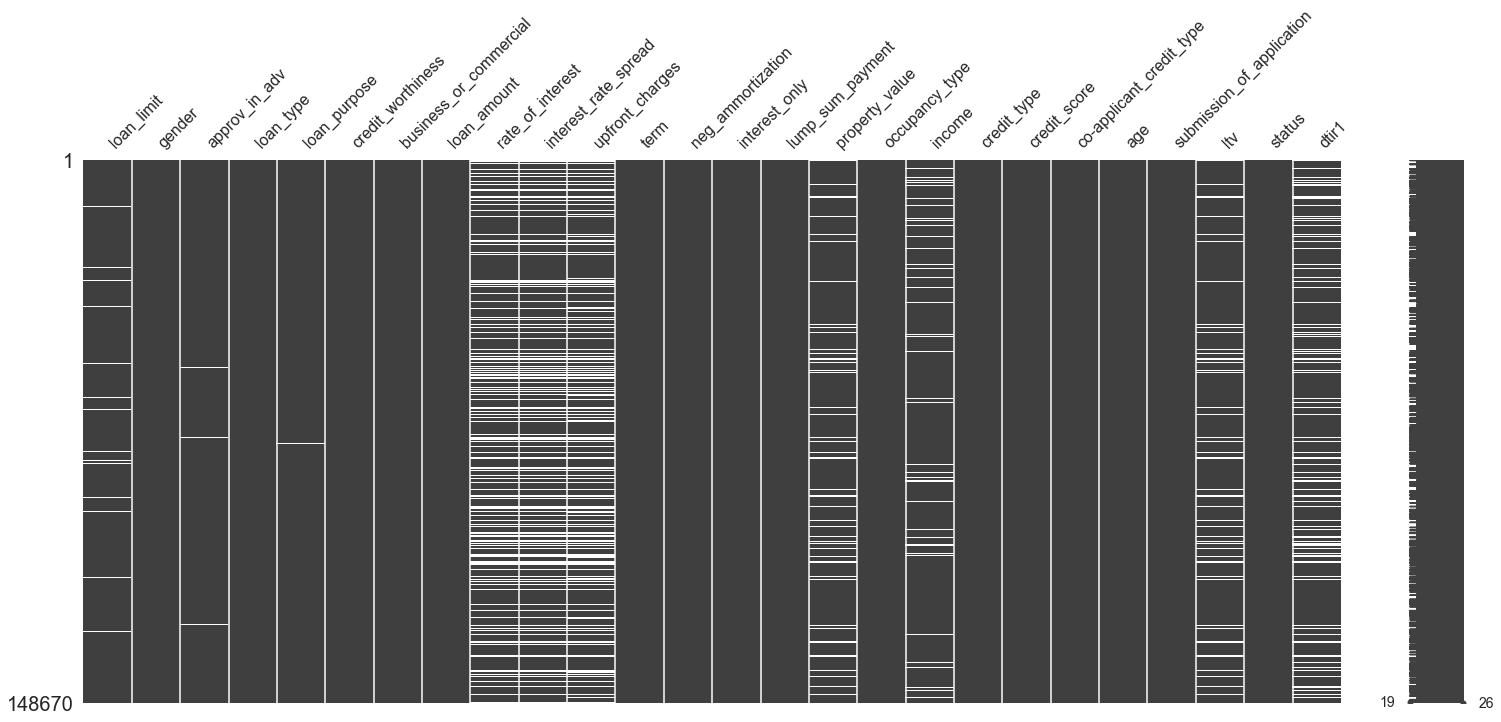

<Figure size 1080x504 with 0 Axes>

In [14]:
# Visuallize missing data
msno.matrix(data)
plt.figure(figsize = (15,7))
plt.show()

Using a heatmap to view *nullity correlation* of missing values. 
 
Correlation ranges from(-1 to 1):
- -1 means if one column(attribute) is present, the other is almost certainly absent.
- 0 means there is no dependence between the columns(attributes).
- 1 means if one column(attributes) is present, the other is also certainly present.

<AxesSubplot:>

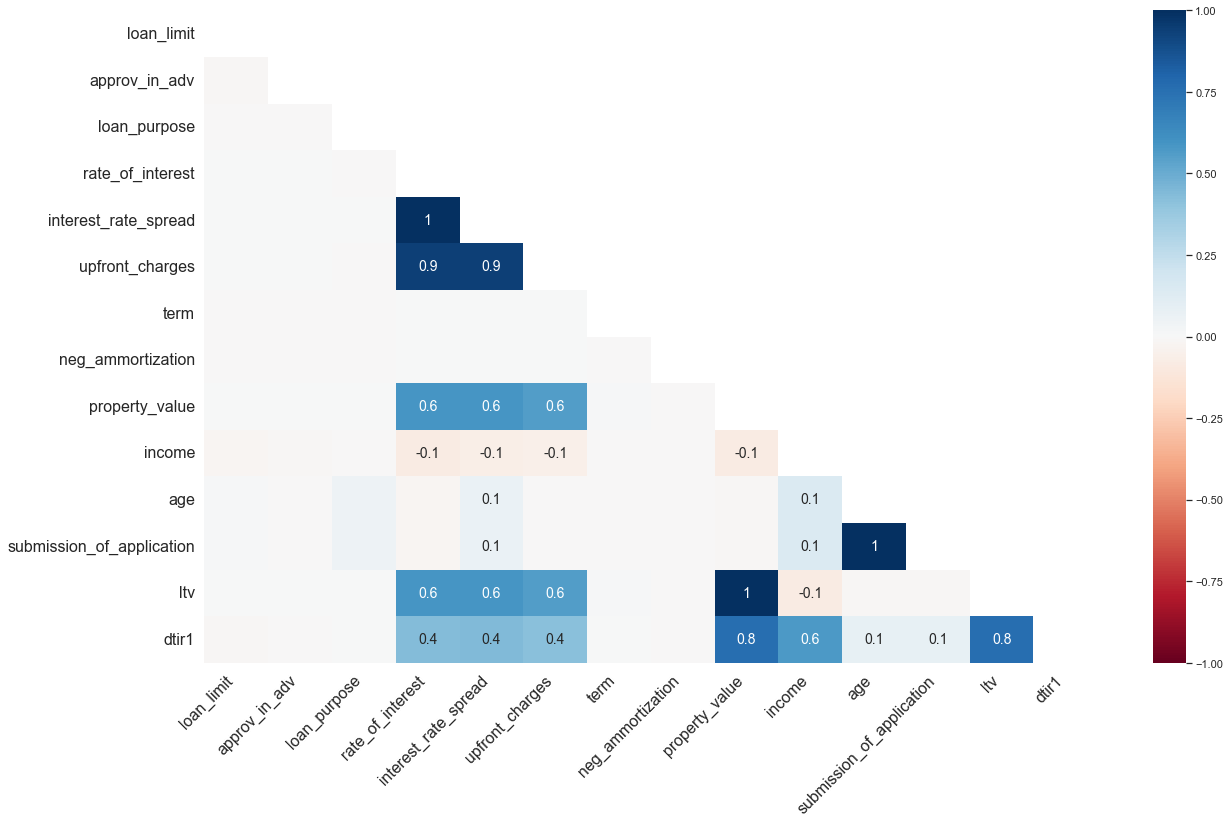

In [15]:
msno.heatmap(data, labels = True) #, figsize = (10, 4))

In [ ]:
# df_defaulted = data[data['status'] == 1]
# df_defaulted.shape[0]

# missing_cols_in_default = [col for col in data.columns if data[col].isnull().sum() > 0]
# missing_cols_in_default

# get_missing_numerical_summary(df_defaulted)

#### Will come back to deal with missing data

## Data Exploration:
---

#### Notes: <br>
- LTV = (loan_amount/property_value)*100 --> LTV is loan-to-value but LTV is multiplied by 100 in the dataset
- ditr1 is debt-to-income ratio. This typically respresnts the portion of the borrower's monthly income that goes towards paying thier debt. I wonder if income is a monthly income number then...

In [16]:
data.describe()

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,dtir1
count,148670.00,112231.00,112031.00,109028.00,148629.00,133572.00,139520.00,148670.00,133572.00,148670.00,124549.00
mean,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,0.25,37.73
std,183909.31,0.56,0.51,3251.12,58.41,359935.32,6496.59,115.88,39.97,0.43,10.55
min,16500.00,0.00,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,0.00,5.00
25%,196500.00,3.62,0.08,581.49,360.00,268000.00,3720.00,599.00,60.47,0.00,31.00
50%,296500.00,3.99,0.39,2596.45,360.00,418000.00,5760.00,699.00,75.14,0.00,39.00
75%,436500.00,4.38,0.78,4812.50,360.00,628000.00,8520.00,800.00,86.18,0.00,45.00
max,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,1.00,61.00


#### What is LTV? <br>
I suspect it is loan-to-value...but let's see:

In [17]:
# First, what is LTV? I suspect it is loan-to-value
ltv_calc = (data['loan_amount']/data['property_value'])
ltv_calc.head(10)
data['ltv'].head(10)
ltv_calc*100

data['ltv'] - (ltv_calc*100)
# LTV is multipled by 100 in the dataset, but it does in fact repesent the loan-to-value
# LTV = (loan_amount/property_value)*100

0         0.00
1          NaN
2         0.00
3         0.00
4         0.00
          ... 
148665    0.00
148666   -0.00
148667   -0.00
148668    0.00
148669    0.00
Length: 148670, dtype: float64

#### Yes, LTV is loan-to-value. In the dataset, LTV is multipled by 100. <br>
LTV = (loan_amount/property_value)*100

#### What is dtir1? <br>
I suspect it is the debt-to-income ratio. However I'm not sure whether by "debt" that means the total debt the borrower inclusive of loans from other institutions or just the debt associated with this particular loan the individual has. Also, debt-to-income is typically measured in terms of monthly income. 

In [18]:
data[['loan_amount', 'term', 'income', 'dtir1']].head(10)

,loan_amount,term,income,dtir1
0,116500,360.00,1740.00,45.00
1,206500,360.00,4980.00,NaN
2,406500,360.00,9480.00,46.00
3,456500,360.00,11880.00,42.00
4,696500,360.00,10440.00,39.00
5,706500,360.00,10080.00,40.00
6,346500,360.00,5040.00,44.00
7,266500,360.00,3780.00,42.00
8,376500,360.00,5580.00,44.00
9,436500,360.00,6720.00,30.00


In [19]:
# ----------------------------------------------
# Trying different ways of calculating the dtir to see if I can get the dtir1 from the dataset:
# ----------------------------------------------

dtir_calc = ((data['loan_amount'])/data['income']) ## ------> NO
dtir_calc 

# Using loan amount divided by it's term (a VERY rough approximation for the monthly pmt) and income (assuming income is monthly)
dtir_calc = (data['loan_amount']/data['term'])/data['income'] ## -----> NOP
dtir_calc 

# # Maybe income is not monthly, try multiplying income by 12...
dtir_calc = data['loan_amount']/(data['income']*12) ## -------> ALSO NO
dtir_calc 

# # Maybe debt (the numerator) is monthly, try multiplying debt by 12...
dtir_calc = (data['loan_amount']*12)/(data['income']) ## -------> ALSO NO...
dtir_calc 

0        803.45
1        497.59
2        514.56
3        461.11
4        800.57
          ...  
148665   666.41
148666   985.71
148667   776.52
148668   330.25
148669   671.90
Length: 148670, dtype: float64

#### I'm not certain how the DTIR is calculated in this dataset. I suspect it is inclusive of the borrower's debt from other institutions, for now I assume that it is.  Another assumption I'm going to make is that the DTIR1 measure is multplied by 100 just like the LTV measure. <br>

#### Because we can, let's reverse engineer the DTIR1 measure to see how much debt these borrowers are in....

**Let:** <br>
- L = loan amount
- V = property value
- D = Debt amount (unclear whether this is total debt of the borrower or just debt to this loan)
- I = income of the borrower 

</br>

**Then we have the following constructions:** <br>
- Loan-to-value (LTV) = L/V
- Debt-to-Income Ratio (DTIR) = D/I

</br>

**So now do simple algebra to solve for total debt:** <br>
- **D = DTIR / I**


In [20]:
# Given that we know the debt-to-income ratio and the income of the borrower, let's see how much debt they are in...
borrower_total_debt = (data['dtir1']/100)*data['income']
borrower_total_debt 

0         783.00
1            NaN
2        4360.80
3        4989.60
4        4071.60
           ...  
148665   3772.80
148666   1071.00
148667   3381.00
148668   2070.60
148669   3194.40
Length: 148670, dtype: float64

In [41]:
df_raw.query('rate_of_interest == 0').shape[0]

1

### Check out the skew on the features:

In [21]:
data.skew().sort_values(ascending = False).reset_index()

,index,0
0,ltv,120.62
1,income,17.31
2,property_value,4.59
3,upfront_charges,1.75
4,loan_amount,1.67
5,status,1.18
6,rate_of_interest,0.39
7,interest_rate_spread,0.28
8,credit_score,0.00
9,dtir1,-0.55


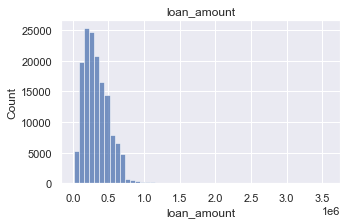

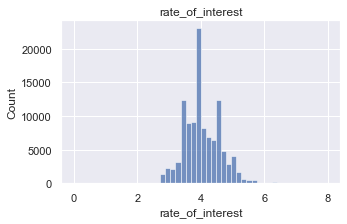

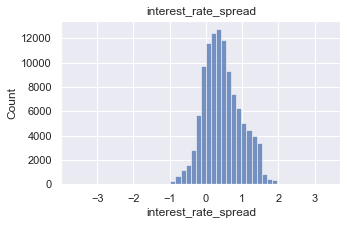

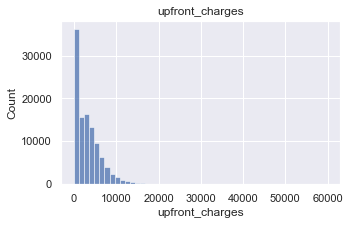

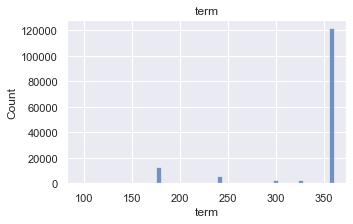

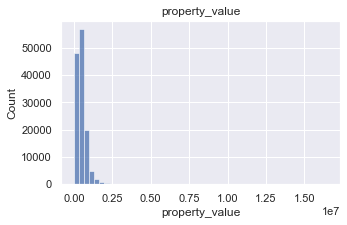

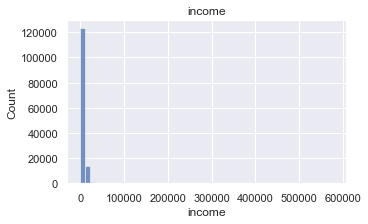

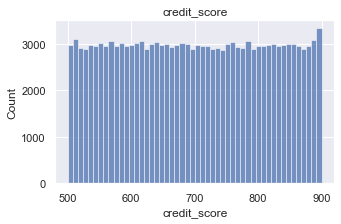

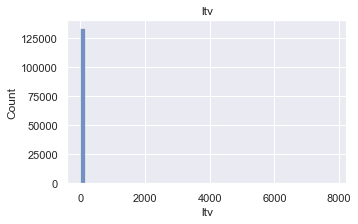

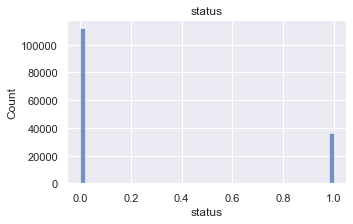

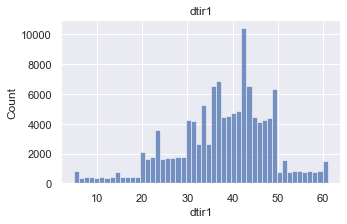

In [24]:
for col_i in numeric_cols:
    plt.figure(figsize = (5,3)) # need this for each plot to be rendered, otherwise shows only last plot
    #px.histogram(data, x = col_i, nbins = 50)
    sns.histplot(data = data, x = col_i, bins = 50)
    plt.title(col_i)
    plt.xlabel(col_i)
    plt.show()
    #print(col_i)
#plt.show()

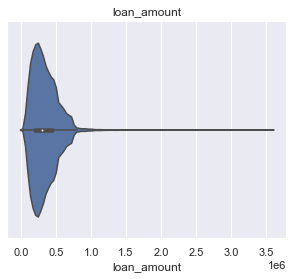

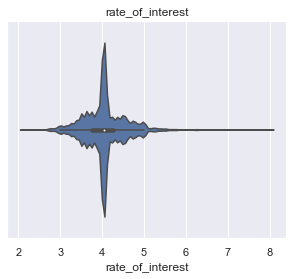

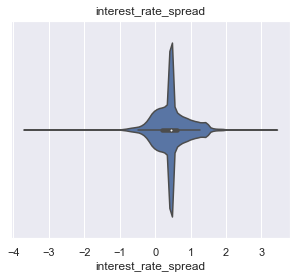

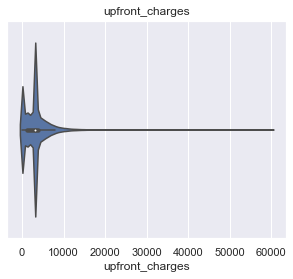

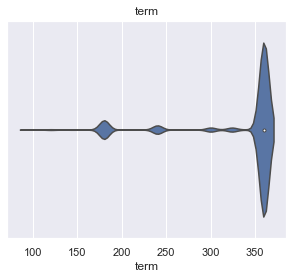

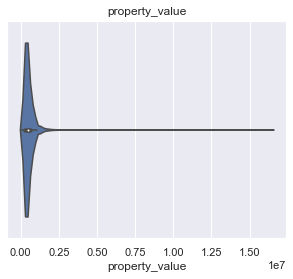

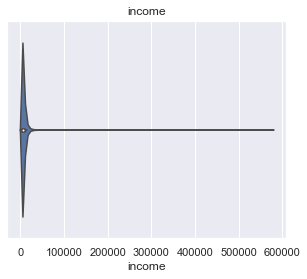

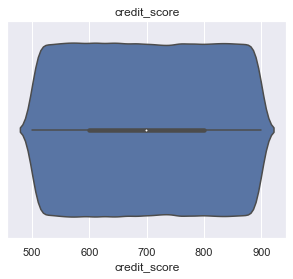

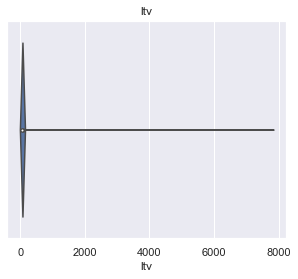

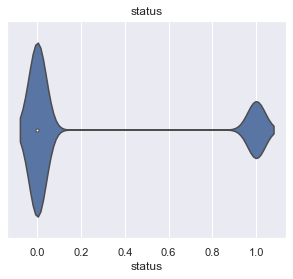

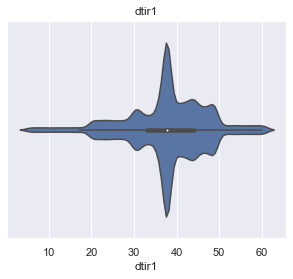

In [150]:
# Violin plots
for col_i in numeric_cols:
    plt.figure(figsize = (5,4)) # need this for each plot to be rendered, otherwise shows only last plot
    sns.violinplot(data = data, x = col_i)
    plt.title(col_i)
    plt.xlabel(col_i)
    plt.show()

In [157]:
#data.quantile(q = .95, axis = 0)

loan_amount             656500.00
rate_of_interest             4.99
interest_rate_spread         1.32
upfront_charges           8350.16
term                       360.00
property_value         1008000.00
income                   15060.00
credit_score               881.00
ltv                         98.08
status                       1.00
dtir1                       52.00
Name: 0.95, dtype: float64

In [22]:
data.describe()

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,dtir1
count,148670.00,112231.00,112031.00,109028.00,148629.00,133572.00,139520.00,148670.00,133572.00,148670.00,124549.00
mean,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,0.25,37.73
std,183909.31,0.56,0.51,3251.12,58.41,359935.32,6496.59,115.88,39.97,0.43,10.55
min,16500.00,0.00,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,0.00,5.00
25%,196500.00,3.62,0.08,581.49,360.00,268000.00,3720.00,599.00,60.47,0.00,31.00
50%,296500.00,3.99,0.39,2596.45,360.00,418000.00,5760.00,699.00,75.14,0.00,39.00
75%,436500.00,4.38,0.78,4812.50,360.00,628000.00,8520.00,800.00,86.18,0.00,45.00
max,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,1.00,61.00


In [23]:
for col_i in numeric_cols:
    if data[col_i].min() == 0:
        print(col_i)

rate_of_interest
upfront_charges
income
status


In [54]:
# Identify relatively strongly correlated features
#sorted_mat[abs(sorted_mat['correlation']) >= 0.15]

## Handling missing data:
___

#### What happens if we want to drop some missing data...

Let's check how much of our data still contains default records (status = 1) if I drop all NaN values...

In [25]:
df_temp = data.dropna()
print("% data loss if remove all rows with NaN: " + str(1-(df_temp.shape[0]/data.shape[0])))

% data loss if remove all rows with NaN: 0.33956413533328844


Come back and decide how to handle missing data...Will lose ~34% of data if delete all NaNs

In [2]:
#df_temp[df_temp['status'] == 1]

Well we can't drop all NaN records because that will leave us with zero true labels...will have to use **imputation** to fill this missing values

In [4]:
#not_missing_cols = [col for col in data.columns if data[col].notnull().sum() > 0]
#not_missing_cols 

### Handling missing data in categorical columns

For categorical features, we can treat missing values as it's own naturally occuring category. Instead of deleting rows where these features are empty, I will flag these records a "missing".

In [21]:
#data = pd.read_csv(str(os.getcwd()) + '\\data_prepped_V1.csv')
df_imputed = data.copy()
df_imputed.describe()

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,dtir1
count,148670.00,112231.00,112031.00,109028.00,148629.00,133572.00,139520.00,148670.00,133572.00,148670.00,124549.00
mean,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,0.25,37.73
std,183909.31,0.56,0.51,3251.12,58.41,359935.32,6496.59,115.88,39.97,0.43,10.55
min,16500.00,0.00,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,0.00,5.00
25%,196500.00,3.62,0.08,581.49,360.00,268000.00,3720.00,599.00,60.47,0.00,31.00
50%,296500.00,3.99,0.39,2596.45,360.00,418000.00,5760.00,699.00,75.14,0.00,39.00
75%,436500.00,4.38,0.78,4812.50,360.00,628000.00,8520.00,800.00,86.18,0.00,45.00
max,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,1.00,61.00


In [22]:
cat_missing_cols = [col for col in missing_cols if data[col].dtype == 'object']
cat_missing_cols

# a = list(set(object_cols).intersection(missing_cols))
# a

['loan_limit',
 'approv_in_adv',
 'loan_purpose',
 'neg_ammortization',
 'age',
 'submission_of_application']

In [23]:
# Replace all missing categories
df_imputed[cat_missing_cols] = df_imputed[cat_missing_cols].fillna('Missing')

In [24]:
# categorical column have no NaNs now:
df_imputed.isna().sum()

loan_limit                       0
gender                           0
approv_in_adv                    0
loan_type                        0
loan_purpose                     0
credit_worthiness                0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
interest_rate_spread         36639
upfront_charges              39642
term                            41
neg_ammortization                0
interest_only                    0
lump_sum_payment                 0
property_value               15098
occupancy_type                   0
income                        9150
credit_type                      0
credit_score                     0
co-applicant_credit_type         0
age                              0
submission_of_application        0
ltv                          15098
status                           0
dtir1                        24121
dtype: int64

In [25]:
df_imputed.describe()

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,dtir1
count,148670.00,112231.00,112031.00,109028.00,148629.00,133572.00,139520.00,148670.00,133572.00,148670.00,124549.00
mean,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,0.25,37.73
std,183909.31,0.56,0.51,3251.12,58.41,359935.32,6496.59,115.88,39.97,0.43,10.55
min,16500.00,0.00,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,0.00,5.00
25%,196500.00,3.62,0.08,581.49,360.00,268000.00,3720.00,599.00,60.47,0.00,31.00
50%,296500.00,3.99,0.39,2596.45,360.00,418000.00,5760.00,699.00,75.14,0.00,39.00
75%,436500.00,4.38,0.78,4812.50,360.00,628000.00,8520.00,800.00,86.18,0.00,45.00
max,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,1.00,61.00


### Handling missing data in numerical columns: <br>

https://machinelearningmastery.com/handle-missing-data-python/

In [ ]:
# df_defaulted = data[data['status'] == 1]
# df_defaulted.shape[0]

# missing_cols_in_default = [col for col in data.columns if data[col].isnull().sum() > 0]
# missing_cols_in_default

# get_missing_numerical_summary(df_defaulted)

In [26]:
num_missing_cols = list(set(numeric_cols).intersection(missing_cols))
num_missing_cols

['rate_of_interest',
 'ltv',
 'term',
 'dtir1',
 'upfront_charges',
 'property_value',
 'interest_rate_spread',
 'income']

For now I will not drop any of the features... <br>

### Simple imputation method (mean) <br>
Note: for some features, such as interest rate, it would be better to replace the missing values with the average rate of the corresponding loan term (a 20 year loan will almost certainly have a higher interest rate than a 5 year loan...)

In [35]:
#df_imputed.to_csv('df_categories_imputed.csv', index=False)
#df_imputed = pd.read_csv(str(os.getcwd()) + '\\df_categories_imputed.csv')

In [28]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_imputed[num_missing_cols] = imputer.fit_transform(df_imputed[num_missing_cols])

In [29]:
df_imputed.describe()

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,dtir1
count,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00
mean,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,0.25,37.73
std,183909.31,0.49,0.45,2784.13,58.40,341169.61,6293.49,115.88,37.88,0.43,9.65
min,16500.00,0.00,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,0.00,5.00
25%,196500.00,3.75,0.18,1250.00,360.00,288000.00,3840.00,599.00,63.30,0.00,33.00
50%,296500.00,4.05,0.44,3225.00,360.00,458000.00,6000.00,699.00,73.03,0.00,37.73
75%,436500.00,4.25,0.62,3889.49,360.00,598000.00,8280.00,800.00,84.72,0.00,44.00
max,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,1.00,61.00


In [31]:
# Now there is no more missing categorical data in our dataset. 
df_imputed.isna().sum()

loan_limit                   0
gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
credit_worthiness            0
business_or_commercial       0
loan_amount                  0
rate_of_interest             0
interest_rate_spread         0
upfront_charges              0
term                         0
neg_ammortization            0
interest_only                0
lump_sum_payment             0
property_value               0
occupancy_type               0
income                       0
credit_type                  0
credit_score                 0
co-applicant_credit_type     0
age                          0
submission_of_application    0
ltv                          0
status                       0
dtir1                        0
dtype: int64

In [32]:
# Recall that earlier there was one record with rate_of_interest = 0%:
df_imputed['rate_of_interest']=df_imputed['rate_of_interest'].replace(0, df_imputed['rate_of_interest'].mean())
df_imputed.describe()

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,dtir1
count,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00
mean,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,0.25,37.73
std,183909.31,0.49,0.45,2784.13,58.40,341169.61,6293.49,115.88,37.88,0.43,9.65
min,16500.00,2.12,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,0.00,5.00
25%,196500.00,3.75,0.18,1250.00,360.00,288000.00,3840.00,599.00,63.30,0.00,33.00
50%,296500.00,4.05,0.44,3225.00,360.00,458000.00,6000.00,699.00,73.03,0.00,37.73
75%,436500.00,4.25,0.62,3889.49,360.00,598000.00,8280.00,800.00,84.72,0.00,44.00
max,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,1.00,61.00


df_imputed OK up to this point - DO NOT re-run impute

#### View and clear garbage collector

In [410]:
# View objects in the garbage collector so far:
#gc.get_objects()

In [379]:
#gc.collect()

0

## Feature Selection: Analyze Relationships among variables

### Relationship between predictors (multicolinearity check):

#### Numerical variables

In [33]:
# Identify and list numeric type columns only
numeric_cols = list(df_imputed.select_dtypes('number').columns)
print(numeric_cols, '\n')

['loan_amount', 'rate_of_interest', 'interest_rate_spread', 'upfront_charges', 'term', 'property_value', 'income', 'credit_score', 'ltv', 'status', 'dtir1'] 



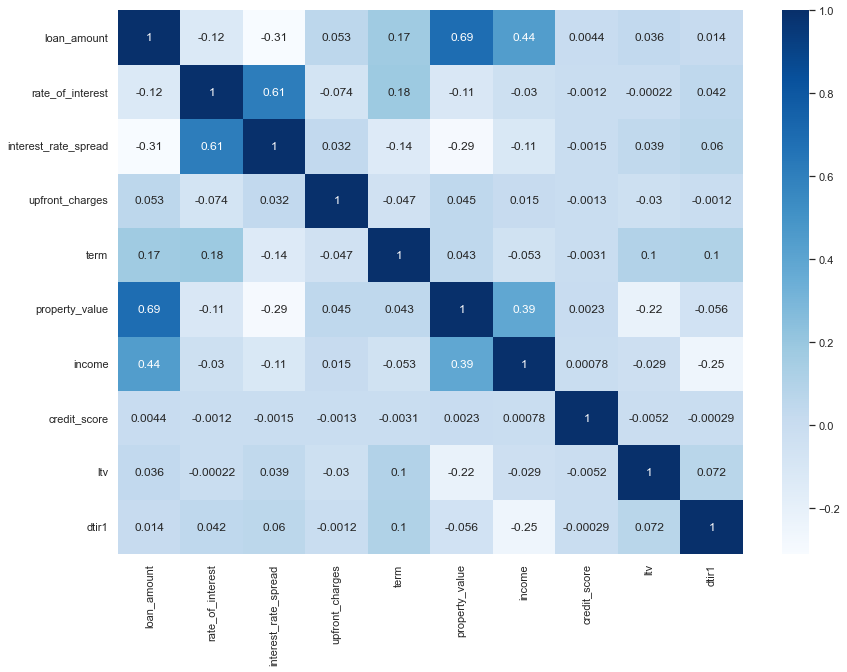

In [34]:
plt.figure(figsize=(14, 10))
sns.heatmap(data=df_imputed[numeric_cols].drop(['status'], axis = 1).corr(),cmap='Blues',annot=True)
plt.show()

In [ ]:
#sns.pairplot(data[numeric_cols].drop('status', axis = 1))

In [35]:
# Correlation matrix:
sorted_corr_mat = df_imputed[numeric_cols].drop(['status'], axis = 1).corr().unstack().sort_values(ascending = False)
sorted_corr_mat

loan_amount           loan_amount             1.00
rate_of_interest      rate_of_interest        1.00
ltv                   ltv                     1.00
credit_score          credit_score            1.00
income                income                  1.00
                                              ... 
                      dtir1                  -0.25
property_value        interest_rate_spread   -0.29
interest_rate_spread  property_value         -0.29
loan_amount           interest_rate_spread   -0.31
interest_rate_spread  loan_amount            -0.31
Length: 100, dtype: float64

In [56]:
# Make a correlation matrix that ignores self-correlated values (a variable is obviously correlated with itself)
# https://www.geeksforgeeks.org/sort-correlation-matrix-in-python/

corr_mat = df_imputed[numeric_cols].drop(['status'], axis = 1).corr()

# Retain upper triangular values of correlation matrix and
# make Lower triangular values Null
upper_corr_mat = corr_mat.where(
    np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
  
# Convert to 1-D series and drop Null values
unique_corr_pairs = upper_corr_mat.unstack().dropna()
  
# Sort correlation pairs
sorted_mat = unique_corr_pairs.sort_values(ascending = False)
#sorted_mat.to_csv('Output_Data\\unique_corr_matrix.csv')

In [82]:
sorted_mat = pd.read_csv(str(os.getcwd()) + '\\Output_Data\\unique_corr_matrix.csv')
sorted_mat.columns = ['v1', 'v2', 'correlation']
sorted_mat.head()

,v1,v2,correlation
0,property_value,loan_amount,0.69
1,interest_rate_spread,rate_of_interest,0.61
2,income,loan_amount,0.44
3,income,property_value,0.39
4,term,rate_of_interest,0.18


In [63]:
# Identify relatively strongly correlated features
high_corr = sorted_mat[abs(sorted_mat['correlation']) >= 0.2]
high_corr

,v1,v2,correlation
0,property_value,loan_amount,0.69
1,interest_rate_spread,rate_of_interest,0.61
2,income,loan_amount,0.44
3,income,property_value,0.39
41,ltv,property_value,-0.22
42,dtir1,income,-0.25
43,property_value,interest_rate_spread,-0.29
44,interest_rate_spread,loan_amount,-0.31


In the table above shows that there exists a linear (approx. linear) relationship between the following predictors: <br>
- property value and loan amount
- interest rate spread and rate of interest
- income and loan amount
- income and property value
- loan-to-value (LTV) and property value
- debt-to-income ratio (dtir1) and income
- property value and interest rate spread
- interest rate spread and loan amount

In [79]:
high_corr_features  = list(np.unique(np.array(list(high_corr['v1']) + list(high_corr['v2']))))
high_corr_features

['dtir1',
 'income',
 'interest_rate_spread',
 'loan_amount',
 'ltv',
 'property_value',
 'rate_of_interest']

In [81]:
# for col_i in high_corr_features:
#     plt.figure()
#     sns.histplot(data=df_imputed, x=col_i, hue='status',  multiple="dodge", shrink=.8)
#     plt.show()

In [ ]:
# for i in object_cols:
#     if len(data[i].unique())<25:
#         boxxx = px.box(data_frame=data,x=i,y='Price')
#         boxxx.show()

### Relationship between predictors and response (features and label):

#### Directional Relationship: a simple logistic regression

To determine the directional relationship of the features and the default status (label) we fit a simple logistic regression and analyzed the coefficents. 
- scale training set
- fit scaled training set
- extract coefficients for each feature from simple logistic regression

#### Numerical features

In [36]:
# test_num_cols = ['loan_amount', 'rate_of_interest','term','property_value',
#                      'income', 'credit_score', 'ltv','dtir1', 'status']
df_imputed[numeric_cols].drop('status', axis = 1).describe()

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,dtir1
count,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00
mean,331117.74,4.05,0.44,3225.00,335.14,497893.47,6957.34,699.79,72.75,37.73
std,183909.31,0.49,0.45,2784.13,58.40,341169.61,6293.49,115.88,37.88,9.65
min,16500.00,2.12,-3.64,0.00,96.00,8000.00,0.00,500.00,0.97,5.00
25%,196500.00,3.75,0.18,1250.00,360.00,288000.00,3840.00,599.00,63.30,33.00
50%,296500.00,4.05,0.44,3225.00,360.00,458000.00,6000.00,699.00,73.03,37.73
75%,436500.00,4.25,0.62,3889.49,360.00,598000.00,8280.00,800.00,84.72,44.00
max,3576500.00,8.00,3.36,60000.00,360.00,16508000.00,578580.00,900.00,7831.25,61.00


#### Simple logistic regression on the numeric columns

In [37]:
#test_num_cols = ['income_to_loan', 'rate_of_interest','term','property_value','credit_score', 'ltv','dtir1', 'status']
X_train = df_imputed[numeric_cols].drop('status', axis = 1).copy()
X_train 
y_train = df_imputed['status'].copy()

In [38]:
# Scale dataset:
mu = X_train.mean()
std = X_train.std()
X_train_scaled =  (X_train - mu) / std
#X_test_scaled = (X_test - mu) / std

# Create lists to hold logistic regression models and feature names
lrs = []
cnames = []

# Run simple logistic regression for each variable 
for col in X_train.columns:
    lr = LogisticRegression()
    lr.fit(X_train_scaled[col].values.reshape(-1, 1),y_train)
    lrs.append(lr)
    cnames.append(col)

# Calculate coef for each feature in simple logistic regressions
df_lrs = pd.DataFrame([cnames,lrs],['feature','LogisticRegression Model']).T
df_lrs['coef'] = df_lrs['LogisticRegression Model'].apply(lambda x:x.coef_[0][0])
df_lrs.filter(['feature','coef'],axis=1).sort_values('coef',ascending=False)


,feature,coef
8,ltv,0.24
9,dtir1,0.15
7,credit_score,0.01
1,rate_of_interest,0.00
2,interest_rate_spread,-0.00
4,term,-0.00
3,upfront_charges,-0.00
0,loan_amount,-0.09
5,property_value,-0.10
6,income,-0.25


Based on the logistic regression results above, there is a positive relationship between the default status (the target) and `ltv` and `dtir1`, and a negative relationship between `loan_amount`, `property_value` and `income`.

In [109]:
# fig, axes = plt.subplots(2,2, figsize = (20,10), sharex = False)
# fig.suptitle('Count by income, loan amount, and property value')
# sns.histplot(data=df_temp, x="income", bins=100, ax=axes[0,0])
# sns.histplot(data=df_temp, x="loan_amount", bins=100, ax=axes[0,1])
# sns.histplot(data=df_temp, x="property_value", bins=100, ax=axes[1,0])

#### Categorical features

Machine learning algorithms can only work with numerical data. Therefore, categorical features and/or target variables require some transformtion in order to be properly interpreted and analyzed by an ML model. These transformations are referred to as *encoding*.

There are two general types of categorical variables: **ordinal**, **nominal** and **binary**, <br>
1. **Ordinal** categorical variables have an inherent order. An example of an ordinal categorgy is size (small, medium, and large) or customer satisfaction ratings (1 star, ..., 5 stars).
2. **Nominal** categorical variables do not have an inherent order (gender, dog breed, musical genre, etc.)   
3. **Binary** variables consists of only 0's and 1's (True/False, Yes/No)

Types of encoding:
1. **Binary** - for binary features/target variables
2. **Label encoding** - for ordinal features/target variables
3. **One-hot encoding (OHE)** - for nominal fatures/target variables
 

Though most examples of categorical variables are easily classified as ordinal vs nominal at face value, what really matters is the type of model you plan to implement. If you choose a model that seeks a linear relationship between the feature and response, then you need to assess the in-sample relationship between the feature and the response variable to determine whether an ordinal vs. nominal characterization is appropriate.
<br>

For binary classification problems, one thing to look at is the average values of the response variable for each level. These average values represent the "rates" of the positive class for each level of the feature.


Plot the average values of the response variable for each level

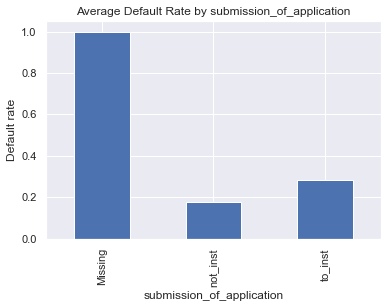

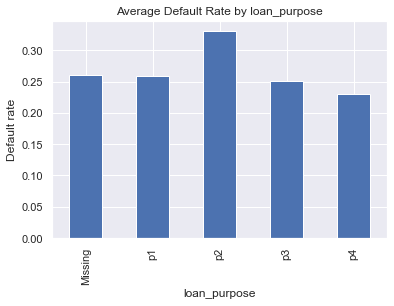

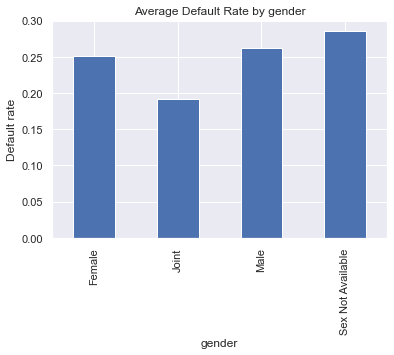

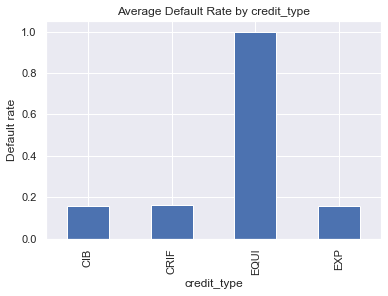

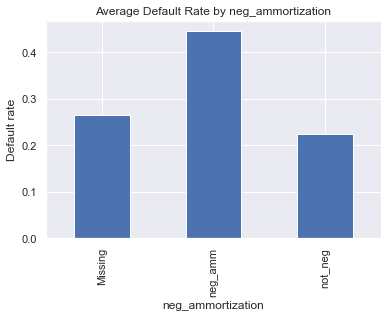

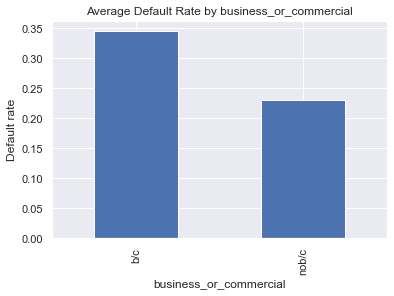

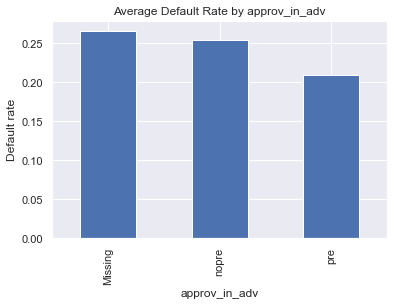

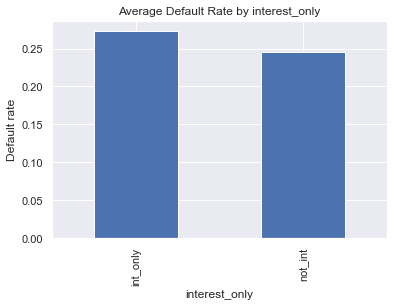

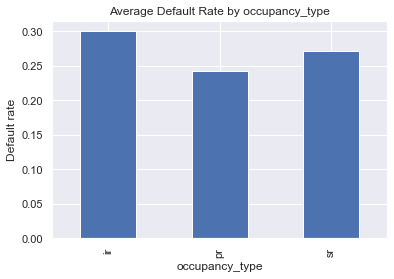

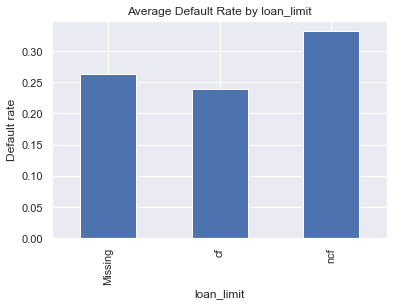

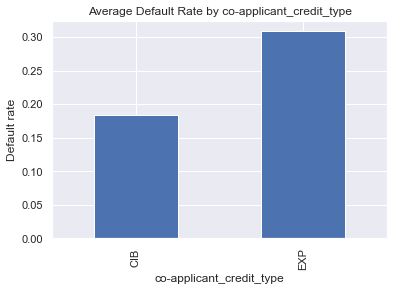

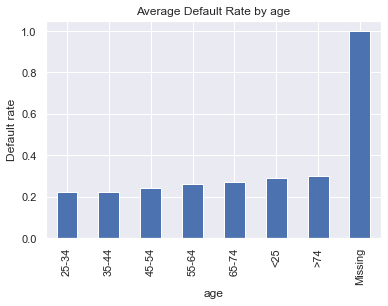

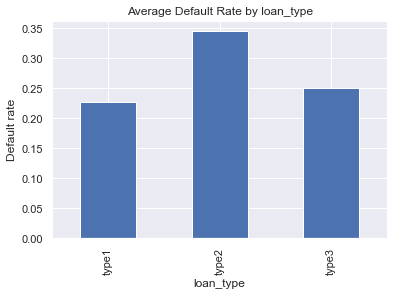

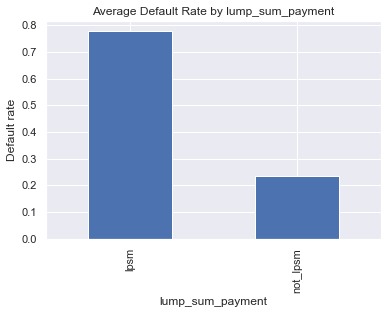

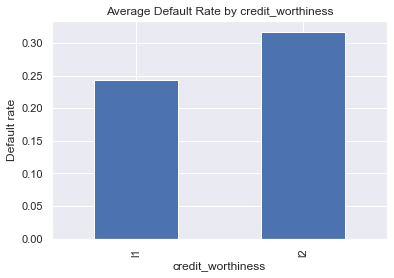

In [40]:
for col_i in object_cols:
    
    df_imputed.groupby(col_i).agg({'status':'mean'}).plot.bar(legend=False)
    plt.title("Average Default Rate by " + str(col_i))
    plt.ylabel('Default rate')

In [ ]:
from sklearn.preprocessing import LabelEncoder

#### Plot count by categorical variables:

In [242]:
type(object_cols)

set

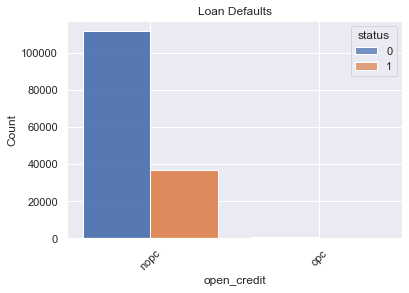

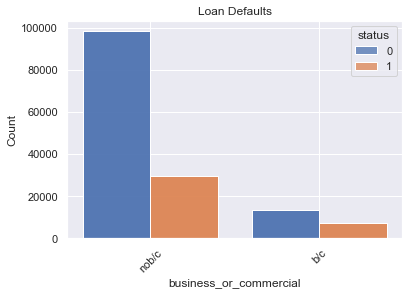

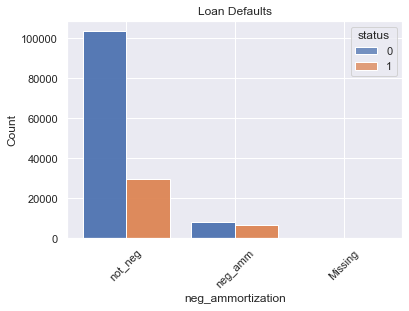

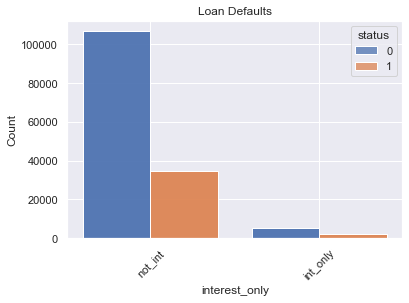

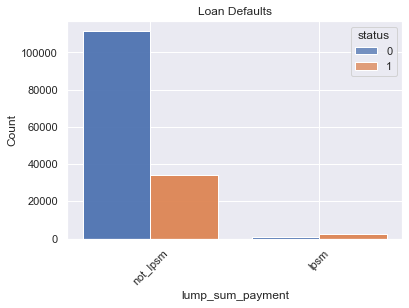

In [159]:
for col_i in object_cols[6:11]:
    value_counts_column =  df_imputed[col_i].value_counts()
    #if value_counts_column.shape[0] > 20:
    value_counts_column = value_counts_column.sort_values(ascending = False)
    value_counts_column = value_counts_column[:20]
    df_aux = data[data[col_i].isin(value_counts_column[:20].index)]
    ax = sns.histplot(data=df_aux, x=col_i, hue='status',  multiple="dodge", shrink=.8)
    ax = sns.histplot(data=df_aux, x=col_i, hue='status',  multiple="dodge", shrink=.8)

    plt.title("Loan Defaults")
    plt.xlabel(col_i)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

## Feature Selection:

#### Revist relationship among features:

In [66]:
# Identify relatively strongly correlated features
sorted_mat[abs(sorted_mat['correlation']) >= 0.15]

,v1,v2,correlation
0,property_value,loan_amount,0.69
1,interest_rate_spread,rate_of_interest,0.61
2,income,loan_amount,0.44
3,income,property_value,0.39
4,term,rate_of_interest,0.18
5,term,loan_amount,0.17
41,ltv,property_value,-0.22
42,dtir1,income,-0.25
43,property_value,interest_rate_spread,-0.29
44,interest_rate_spread,loan_amount,-0.31


#### Drop some correlated features:
Choosing one element from each correlated pair to drop (Note: further analysis could be done to determine which of element of each pair to drop based on the the relationship to the target. For the sake of this analysis I will just choose one.) 

In [147]:
del_num_cols = ['property_value', 'interest_rate_spread', 'term', 'upfront_charges']
keep_num_cols = list(set(numeric_cols) - set(del_num_cols))

keep_obj_cols = ['gender', 'loan_purpose', 'credit_type', 'age']
del_obj_cols = list(set(object_cols) - set(keep_obj_cols))

# All columns removed:
del_cols = del_num_cols + del_obj_cols

# All columns to keep:
keep_cols = keep_num_cols + keep_obj_cols
keep_cols

['loan_amount',
 'income',
 'credit_score',
 'ltv',
 'dtir1',
 'status',
 'rate_of_interest',
 'gender',
 'loan_purpose',
 'credit_type',
 'age']

['loan_amount',
 'income',
 'credit_score',
 'ltv',
 'dtir1',
 'status',
 'rate_of_interest',
 'income_to_loan']

#### I'll create one engineered feature: `income_to_loan` <br>


In [148]:
data['income_to_loan'] = data['income']/data['loan_amount']
#data = data.drop((['income', 'loan_amount']), axis = 1)

# data['income_to_loan'] = data['income']/data['loan_amount']
# data = data.drop((['income', 'loan_amount']), axis = 1)

# keep_cols = ['credit_score', 'ltv', 'dtir1', 'status', 'rate_of_interest', 'gender',
#              'loan_purpose', 'credit_type', 'age', 'income_to_loan']

In [149]:
keep_num_cols = keep_num_cols + ['income_to_loan']
keep_num_cols

# All columns to keep:
keep_cols = keep_num_cols + keep_obj_cols
keep_cols

['loan_amount',
 'income',
 'credit_score',
 'ltv',
 'dtir1',
 'status',
 'rate_of_interest',
 'income_to_loan',
 'gender',
 'loan_purpose',
 'credit_type',
 'age']

In [153]:
keep_num_cols

['loan_amount',
 'income',
 'credit_score',
 'ltv',
 'dtir1',
 'status',
 'rate_of_interest',
 'income_to_loan']

In [150]:
df_clean = data[keep_cols].drop(['loan_amount', 'income'], axis = 1)
df_clean.columns

Index(['credit_score', 'ltv', 'dtir1', 'status', 'rate_of_interest',
       'income_to_loan', 'gender', 'loan_purpose', 'credit_type', 'age'],
      dtype='object')

In [151]:
df_clean.info()
df_clean.describe()
#df_clean.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   credit_score      148670 non-null  int64  
 1   ltv               148670 non-null  float64
 2   dtir1             148670 non-null  float64
 3   status            148670 non-null  int64  
 4   rate_of_interest  148670 non-null  float64
 5   income_to_loan    148670 non-null  float64
 6   gender            148670 non-null  object 
 7   loan_purpose      148670 non-null  object 
 8   credit_type       148670 non-null  object 
 9   age               148670 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 11.3+ MB


,credit_score,ltv,dtir1,status,rate_of_interest,income_to_loan
count,148670.00,148670.00,148670.00,148670.00,148670.00,148670.00
mean,699.79,72.75,37.73,0.25,4.05,0.02
std,115.88,37.88,9.65,0.43,0.49,0.02
min,500.00,0.97,5.00,0.00,2.12,0.00
25%,599.00,63.30,33.00,0.00,3.75,0.01
50%,699.00,73.03,37.73,0.00,4.05,0.02
75%,800.00,84.72,44.00,0.00,4.25,0.03
max,900.00,7831.25,61.00,1.00,8.00,1.67


In [140]:
# New features with one engineered feature
#test_num_cols = list(keep_cols + ['income_to_loan'])[2:12]
#test_num_cols = keep_cols
#= ['income_to_loan', 'rate_of_interest', 'term', 'property_value','credit_score', 'ltv','dtir1', 'status']

In [155]:
temp_cols = ['credit_score', 'ltv', 'dtir1', 'status', 'rate_of_interest', 'income_to_loan']

X_train = df_clean[temp_cols].drop('status', axis = 1)
X_train 
y_train = df_clean['status']

In [156]:
# Scale dataset:
mu = X_train.mean()
std = X_train.std()
X_train_scaled = (X_train - mu) / std
#X_test_scaled = (X_test - mu) / std

# Create lists to hold logistic regression models and feature names
lrs = []
cnames = []

# Run simple logistic regression for each variable 
for col in X_train.columns:
    lr = LogisticRegression()
    lr.fit(X_train_scaled[col].values.reshape(-1, 1),y_train)
    lrs.append(lr)
    cnames.append(col)

# Calculate coef for each feature in simple logistic regressions
df_lrs = pd.DataFrame([cnames,lrs],['feature','LinearRegression Model']).T
df_lrs['coef'] = df_lrs['LinearRegression Model'].apply(lambda x:x.coef_[0][0])
df_lrs.filter(['feature','coef'],axis=1).sort_values('coef',ascending=False)

,feature,coef
1,ltv,0.24
2,dtir1,0.15
0,credit_score,0.01
3,rate_of_interest,0.00
4,income_to_loan,-0.10


### Encoding categorical features:

In [82]:
list(df_clean.columns)
#list(keep_obj_cols)
# 'gender', 'loan_purpose', 'credit_type', 'age'

['credit_score',
 'ltv',
 'dtir1',
 'status',
 'rate_of_interest',
 'gender',
 'loan_purpose',
 'credit_type',
 'age',
 'income_to_loan']

In [83]:
#### Encoding categorical independent (predictor) variables:
df_encoded = pd.get_dummies(df_clean, columns= keep_obj_cols, drop_first=True)

df_encoded

,credit_score,ltv,dtir1,status,rate_of_interest,income_to_loan,gender_Joint,gender_Male,gender_Sex Not Available,loan_purpose_p1,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,age_Missing
0,758,98.73,45.00,1,4.05,0.01,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,552,72.75,37.73,1,4.05,0.02,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
2,834,80.02,46.00,0,4.56,0.02,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
3,587,69.38,42.00,0,4.25,0.03,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
4,602,91.89,39.00,0,4.00,0.01,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,659,71.79,48.00,0,3.12,0.02,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
148666,569,74.43,15.00,0,5.19,0.01,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
148667,702,61.33,49.00,0,3.12,0.02,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
148668,737,70.68,29.00,0,3.50,0.04,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0


In [84]:
# Rename columns with a "<" or ">" symbol in them, the XGBoost model will not allow column names with these characters
df_encoded.rename(columns = {'age_<25': 'age_less25', 'age_>74': 'age_less74'}, inplace = True)
#df_encoded.columns

In [85]:
df_X = df_encoded.drop('status', axis = 1)
df_y = df_encoded['status']

In [86]:
df_default = df_clean.loc[df_clean['status'] == 1]
df_no_default = df_clean.loc[df_clean['status'] == 0]
print("# defaulted: " + str(len(df_default)))
print("# Did not default: " + str(len(df_no_default)))

# Note imblanced dataset
df_clean.query('status == 1').shape[0] / df_clean.shape[0]

# defaulted: 36639
# Did not default: 112031


0.24644514696979888

In [87]:
# Train-test split: using stratify = yes to account for imbalance
# stratify = df_y ,
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size = 0.3, random_state = 0)

X_train = X_train.copy()
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()

In [88]:
print("% of default records in training set:  " + str(len(y_train[y_train == 1])/len(y_train)))
print("% of default records in test set:  " + str(len(y_test[y_test == 1])/len(y_test)))

% of default records in training set:  0.24620203903179622
% of default records in test set:  0.24701239882513845


In [89]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

model=DecisionTreeClassifier()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[33583     1]
 [    0 11017]]
0.9999775789780498


#### Fit Base XGBoost regressor model

In [90]:
from sklearn.metrics import f1_score,precision_score,recall_score
from xgboost import XGBClassifier

base_xgb_mdl = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
base_xgb_mdl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

#### Predict using the base XGBoost model

In [63]:
y_train_pred_base_xgb = base_xgb_mdl.predict(X_train)
y_test_pred_base_xgb = base_xgb_mdl.predict(X_test)

#### Access the goodnesss of fit of the base XGBoost model:

In [64]:
from sklearn.metrics import f1_score,precision_score,recall_score

# # F1 score for base model:
train_f1_base_xgb = sklearn.metrics.f1_score(y_train, y_train_pred_base_xgb)
print("Train F1 score associated with Base XG Boost Regression is : ", train_f1_base_xgb,'\n')

test_f1_base_xgb = sklearn.metrics.f1_score(y_test , y_test_pred_base_xgb)
print("Test F1 score associated with Base XG Boost Regression is : ", test_f1_base_xgb,'\n')


# Recall score:
train_recall_base_xgb = sklearn.metrics.recall_score(y_train , y_train_pred_base_xgb)
print("Train recall score associated with Base XG Boost Regression is : ", train_recall_base_xgb,'\n')

test_recall_base_xgb = sklearn.metrics.recall_score(y_test , y_test_pred_base_xgb)
print("Test recall score associated with Base XG Boost Regression is : ", test_recall_base_xgb,'\n')


# Precision score:
train_precision_base_xgb = sklearn.metrics.precision_score(y_train , y_train_pred_base_xgb)
print("Train precision score associated with Base XG Boost Regression is : ", train_precision_base_xgb,'\n')

test_precision_base_xgb = sklearn.metrics.precision_score(y_test , y_test_pred_base_xgb)
print("Test precision score associated with Base XG Boost Regression is : ", test_precision_base_xgb,'\n')


# Compute the mean-squared error for base model:
train_MSE_base_xgb = sklearn.metrics.mean_absolute_error(y_train, y_train_pred_base_xgb)
print("Train MAE associated with Base XG Boost Regression is : ", train_MSE_base_xgb,'\n')

test_MSE_base_xgb = sklearn.metrics.mean_absolute_error(y_test , y_test_pred_base_xgb)
print("Test MAE associated with Base XG Boost Regression is : ", test_MSE_base_xgb,'\n')

Train F1 score associated with Base XG Boost Regression is :  0.9999804859010635 

Test F1 score associated with Base XG Boost Regression is :  0.9999546176537327 

Train recall score associated with Base XG Boost Regression is :  1.0 

Test recall score associated with Base XG Boost Regression is :  1.0 

Train precision score associated with Base XG Boost Regression is :  0.9999609725637123 

Test precision score associated with Base XG Boost Regression is :  0.9999092394263932 

Train MAE associated with Base XG Boost Regression is :  9.609009407220209e-06 

Test MAE associated with Base XG Boost Regression is :  2.2421021950180488e-05 



In [ ]:
# df_scores = pd.DataFrame({'f1_score_train':train_f1_base_xgb, 'f1_score_test':test_f1_base_xgb,
#                           'recall_train': train_recall_base_xgb, 'recall_test': test_recall_base_xgb,
#                           'precision_train':train_precision_base_xgb, 'precision_test':test_precision_base_xgb})